In [ ]:
import torch
import numpy as np
import pandas as pd
import easyocr
from PIL import Image 
import transformers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from transformers import CLIPProcessor, CLIPModel, AutoModelForSeq2SeqLM, AutoTokenizer
from multilingual_clip import pt_multilingual_clip
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"  # Use GPU if available, otherwise fallback to CPU
print(device)

cuda


In [13]:
# Load pre-trained CLIP model and processor
model_name = "M-CLIP/XLM-Roberta-Large-Vit-B-32"
clip_text_model = pt_multilingual_clip.MultilingualCLIP.from_pretrained(model_name)
clip_tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)

clip_model_name = "openai/clip-vit-base-patch32"
clip_model = CLIPModel.from_pretrained(clip_model_name).eval()
clip_processor = CLIPProcessor.from_pretrained(clip_model_name)

c:\Users\sirifris\.conda\envs\poli_reco\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
# def get_text_features(text):
#     """Extracts text features using M-CLIP/XLM-Roberta-Large-Vit-B-32."""
#     try:
#         text_features = clip_text_model.forward([text], clip_tokenizer)
#         return text_features.squeeze().detach().cpu().numpy()  # Convert tensor to numpy array
#     except Exception as e:
#         print(f"⚠️ Error extracting text features: {e}")
#         return None

# Function definitions

In [14]:
def get_text_features(text):
    """Extracts text features using M-CLIP/XLM-Roberta-Large-Vit-B-32, handling long texts."""
    try:
        max_tokens = 512  # 
        # Tokenize the input text
        tokens = clip_tokenizer(text, return_tensors="pt", padding=False, truncation=False).input_ids[0]
        # Ensures no empty chunk is created
        token_chunks = [tokens[i:i + max_tokens] for i in range(0, len(tokens), max_tokens)]
    
        # Check if any chunk is empty (which could happen with very short texts or edge cases)
        if any(len(chunk) == 0 for chunk in token_chunks):
            print("⚠️ Warning: Found empty token chunks!")
            return None  # Early exit if there are empty chunks
        # Decode chunks back into text
        text_chunks = [clip_tokenizer.decode(chunk, skip_special_tokens=True) for chunk in token_chunks]
        
        # Process each chunk and extract its features
        chunk_features = []
        for chunk in text_chunks:
            # Tokenize each chunk and get the model features
            inputs = clip_tokenizer(chunk, return_tensors="pt", padding=True, truncation=True, max_length=512)
            with torch.no_grad():
                features = clip_text_model.forward([chunk], clip_tokenizer).squeeze().cpu().numpy()
            chunk_features.append(features)
        
        # Average the features from all chunks to get the final representation
        final_text_features = np.mean(chunk_features, axis=0) if chunk_features else np.zeros((512,))
        
        return final_text_features
    except Exception as e:
        print(f"⚠️ Error extracting text features: {e}")
        return None

In [15]:
# Initialize EasyOCR reader for OCR
reader = easyocr.Reader(["no", "en"])  # Norwegian and English, because there's some mixing of the languages

def extract_text_easyocr(image_path):
    """Extracts text from an image using EasyOCR."""
    try:
        results = reader.readtext(image_path, detail=0)  # Extract text without coordinates
        return " ".join(results)  # Join extracted words into a single string
    except Exception as e:
        print(f"⚠️ OCR failed for {image_path}: {e}")
        return ""

c:\Users\sirifris\.conda\envs\poli_reco\lib\site-packages\easyocr\detection.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(copyStateDict(torch.load

In [16]:
# Function to extract image features
def get_image_features(image_path):
    """Extracts image embeddings from CLIP."""
    image = Image.open(image_path).convert("RGB")
    inputs = clip_processor(images=image, return_tensors="pt")
    with torch.no_grad():
        image_features = clip_model.get_image_features(**inputs)
    return image_features.cpu().numpy()

# Feature extractions

In [44]:
# loading the data
df = pd.read_excel("D:/sample_images_full.xlsx")
# Fix the labels, 0=non humor, 1=humor
df["label"] = df["label"].apply(lambda x: 1 if x > 0 else 0)
df["image_path_image_filename_image_1"] = df["image_path_image_filename_image_1"].str.replace(r"^D:/", "E:/", regex=True)

In [45]:
# Extract text from images
import PIL
PIL.Image.ANTIALIAS = PIL.Image.LANCZOS
df["image_text"] = df["image_path_image_filename_image_1"].apply(extract_text_easyocr)

c:\Users\sirifris\.conda\envs\poli_reco\lib\site-packages\PIL\Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
c:\Users\sirifris\.conda\envs\poli_reco\lib\site-packages\PIL\Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [46]:
# Create the different feature sets
# df["combined_text"] = df["tweet"] + " " + df["image_text"]
# df["text_features"] = df["combined_text"].apply(get_text_features)
df["text_features"] = df["tweet"].apply(get_text_features)
df["image_text_features"] = df["image_text"].apply(get_text_features)
df["image_features"] = df["image_path_image_filename_image_1"].apply(get_image_features)

Token indices sequence length is longer than the specified maximum sequence length for this model (599 > 512). Running this sequence through the model will result in indexing errors


⚠️ Error extracting text features: The expanded size of the tensor (515) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 515].  Tensor sizes: [1, 514]
⚠️ Error extracting text features: index out of range in self
⚠️ Error extracting text features: index out of range in self
⚠️ Error extracting text features: index out of range in self
⚠️ Error extracting text features: index out of range in self
⚠️ Error extracting text features: index out of range in self
⚠️ Error extracting text features: index out of range in self
⚠️ Error extracting text features: index out of range in self
⚠️ Error extracting text features: index out of range in self
⚠️ Error extracting text features: index out of range in self
⚠️ Error extracting text features: index out of range in self
⚠️ Error extracting text features: index out of range in self


c:\Users\sirifris\.conda\envs\poli_reco\lib\site-packages\PIL\Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [70]:
print(df["text_features"].shape)
print(df["image_text_features"].shape)
print(df["image_features"].shape)

(2165,)
(2165,)
(2165,)


In [48]:
print(df.isnull().sum())

tweet                                   0
label                                   0
id                                      0
date                                    0
image_path_image_filename_image_1       0
image_path_image_filename_image_2    2018
image_path_image_filename_image_3    2108
image_path_image_filename_image_4    2132
image_text                              0
text_features                           0
image_text_features                    12
image_features                          0
dtype: int64


In [49]:
print(df.head)

<bound method NDFrame.head of                                                   tweet  label  \
0     Tror neppe jeg hadde klart å caste en kar som ...      1   
1     NRK forsiden: Kvinne smittet av Coronavirus i ...      0   
2     Da er vi sikra. Vaksinen mot Corona-viruset er...      1   
3     NRK Oslo og Viken: Folkehelsa om corona-karant...      0   
4     NRK Nordland: Ingen grunn til corona-bekymring...      0   
...                                                 ...    ...   
2172  Ville kutte Covid-tiltak siden pandemien er ov...      0   
2173  USERNAME USERNAME Visste noe var galt når trøy...      1   
2174  USERNAME USERNAME USERNAME USERNAME Det er des...      0   
2175  USERNAME USERNAME Mikrobiomet blir i høyeste g...      0   
2176  Tror ikke USERNAME Ola Borten Moe har lært noe...      1   

                       id       date  \
0     1221795275876044801 2020-01-01   
1     1223269853445779456 2020-01-01   
2     1221176911516356608 2020-01-01   
3     12217960068

In [50]:
df = df.dropna(subset=["text_features", "image_text_features", "image_features"])

In [73]:
df["image_features"] = df["image_features"].apply(lambda x: np.squeeze(x))
print("Example shapes:")
print(np.array(df["text_features"].iloc[0]).shape)
print(np.array(df["image_text_features"].iloc[0]).shape)
print(np.array(df["image_features"].iloc[0]).shape)

Example shapes:
(512,)
(512,)
(512,)


# Model training

## Intramodal as differnce between max and min

In [107]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import euclidean

# Function to compute intra-modal incongruity
def intra_modal_difference(embedding):
    embedding = np.array(embedding)  # Ensure it's an array
    return np.max(embedding) - np.min(embedding)


In [108]:
df["I_t"] = df["text_features"].apply(intra_modal_difference)
df["I_s"] = df["image_text_features"].apply(intra_modal_difference)
df["I_i"] = df["image_features"].apply(intra_modal_difference)

In [109]:
print(df[["I_t", "I_s", "I_i"]].head())

        I_t       I_s       I_i
0  7.541688  5.360218  3.618146
1  5.773614  4.716133  8.820479
2  7.432099  4.460142  7.330198
3  6.654484  4.716133  8.769396
4  6.326044  6.075749  6.979046


In [ ]:
from sklearn.preprocessing import StandardScaler

# Split into features and labels
X = df[["I_t", "I_s", "I_i"]].values
y = df["label"].values

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Optional: Normalize the feature values
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
smote = SMOTE(random_state=42)

# Apply SMOTE to balance the classes
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [ ]:
# simple neural network
model = Sequential()

model.add(Dense(128, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l2(0.01)))  # input layer
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))  # hidden layer
model.add(Dropout(0.5))

model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))  # hidden layer
model.add(Dropout(0.5))

# Output layer (binary classification)
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

c:\Users\sirifris\.conda\envs\poli_reco\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [122]:
# Train the model on the resampled data
history_resampled = model.fit(X_train_res, y_train_res, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5138 - loss: 1.7592 - val_accuracy: 0.6212 - val_loss: 1.1339
Epoch 2/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5686 - loss: 1.0344 - val_accuracy: 0.4480 - val_loss: 0.8457
Epoch 3/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5778 - loss: 0.7989 - val_accuracy: 0.4734 - val_loss: 0.7509
Epoch 4/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5995 - loss: 0.7270 - val_accuracy: 0.6305 - val_loss: 0.6967
Epoch 5/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5899 - loss: 0.7053 - val_accuracy: 0.6189 - val_loss: 0.6872
Epoch 6/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5728 - loss: 0.6970 - val_accuracy: 0.6097 - val_loss: 0.6878
Epoch 7/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5779 - loss: 0.6946 - val_accuracy: 0.5012 - val_loss: 0.7096
Epoch 8/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5924 - loss: 0.6940 - val_accuracy: 0.5751 - val_loss: 0.6878
Epo

In [123]:
# Make predictions on the test set
y_pred = (model.predict(X_test) > 0.5).astype("int32")  # Get binary predictions (0 or 1)

# Print detailed classification report (precision, recall, F1 score)
print(classification_report(y_test, y_pred, target_names=["Not Humor", "Humor"]))

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
              precision    recall  f1-score   support

   Not Humor       0.84      0.66      0.74       356
       Humor       0.21      0.42      0.28        77

    accuracy                           0.62       433
   macro avg       0.53      0.54      0.51       433
weighted avg       0.73      0.62      0.66       433



In [ ]:
import keras_tuner as kt

# Define the model building function for Keras Tuner
def build_model(hp):
    model = Sequential()
    model.add(Dense(hp.Int('units', min_value=32, max_value=128, step=32), input_dim=X_train.shape[1], activation='relu'))
    model.add(Dropout(hp.Float('dropout', min_value=0.3, max_value=0.7, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=hp.Choice('optimizer', values=['adam', 'rmsprop']), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Initialize the tuner
tuner = kt.RandomSearch(build_model, objective='val_accuracy', max_trials=5, executions_per_trial=3, directory='tuner', project_name='humor_classification')

# Search for the best hyperparameters
tuner.search(X_train_res, y_train_res, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Train the best model
history_tuned = best_model.fit(X_train_res, y_train_res, epochs=10, batch_size=32, validation_data=(X_test, y_test))

In [57]:
# Make predictions on the test set
y_pred = (best_model.predict(X_test) > 0.5).astype("int32")  # Get binary predictions (0 or 1)

# Print detailed classification report (precision, recall, F1 score)
print(classification_report(y_test, y_pred, target_names=["Not Humor", "Humor"]))

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
              precision    recall  f1-score   support

   Not Humor       0.87      0.64      0.74       356
       Humor       0.25      0.57      0.35        77

    accuracy                           0.63       433
   macro avg       0.56      0.60      0.54       433
weighted avg       0.76      0.63      0.67       433



Not much of an improvement there. Probably need for testing mroe advanced models. 

## intramodal as euclidean distance

In [ ]:
# Euclidean distance for intramodal incongruity:
from scipy.spatial.distance import pdist, squareform

def mean_pairwise_distance(vector):
    distances = pdist(vector.reshape(-1, 1), metric='euclidean')  # Compute all pairwise distances
    return np.mean(distances)

df["intra_text_euclidean"] = df["text_features"].apply(mean_pairwise_distance)
df["intra_image_text_euclidean"] = df["image_text_features"].apply(mean_pairwise_distance)
df["intra_image_euclidean"] = df["image_features"].apply(mean_pairwise_distance)

In [91]:
print(df[["intra_image_euclidean", "intra_text_euclidean", "intra_image_text_euclidean"]].head())

   intra_image_euclidean  intra_text_euclidean  intra_image_text_euclidean
0               0.395758              0.240304                    0.167257
1               0.409263              0.228675                    0.136660
2               0.417482              0.258663                    0.183020
3               0.422360              0.176598                    0.136660
4               0.413199              0.163464                    0.135525


In [ ]:
from sklearn.preprocessing import StandardScaler

# Split into features and labels
X = df[["intra_image_euclidean", "intra_text_euclidean", "intra_image_text_euclidean"]].values
y = df["label"].values

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Optional: Normalize the feature values
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [ ]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [ ]:
model = Sequential()

model.add(Dense(128, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l2(0.01)))  # input layer
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))  # hidden layer
model.add(Dropout(0.5))

model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))  # hidden layer
model.add(Dropout(0.5))

# Output layer (binary classification)
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

c:\Users\sirifris\.conda\envs\poli_reco\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [128]:
history_resampled = model.fit(X_train_res, y_train_res, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5484 - loss: 1.7735 - val_accuracy: 0.6490 - val_loss: 1.1431
Epoch 2/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6360 - loss: 1.0427 - val_accuracy: 0.6721 - val_loss: 0.8223
Epoch 3/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6123 - loss: 0.8025 - val_accuracy: 0.6467 - val_loss: 0.7224
Epoch 4/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6002 - loss: 0.7327 - val_accuracy: 0.6074 - val_loss: 0.7115
Epoch 5/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6183 - loss: 0.6991 - val_accuracy: 0.6259 - val_loss: 0.6802
Epoch 6/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6438 - loss: 0.6783 - val_accuracy: 0.6166 - val_loss: 0.6856
Epoch 7/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6104 - loss: 0.6831 - val_accuracy: 0.6628 - val_loss: 0.6478
Epoch 8/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6346 - loss: 0.6759 - val_accuracy: 0.6328 - val_loss:

In [ ]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred, target_names=["Not Humor", "Humor"]))

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
              precision    recall  f1-score   support

   Not Humor       0.92      0.58      0.71       356
       Humor       0.28      0.78      0.42        77

    accuracy                           0.61       433
   macro avg       0.60      0.68      0.56       433
weighted avg       0.81      0.61      0.66       433



The euclidean distance as a measurement of intramodal incongruity seem to perform better than the min/max difference. 

In [ ]:
# with tuning
import keras_tuner as kt

# Define the model building function for Keras Tuner
def build_model(hp):
    model = Sequential()
    model.add(Dense(hp.Int('units', min_value=32, max_value=128, step=32), input_dim=X_train.shape[1], activation='relu'))
    model.add(Dropout(hp.Float('dropout', min_value=0.3, max_value=0.7, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=hp.Choice('optimizer', values=['adam', 'rmsprop']), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Initialize the tuner
tuner = kt.RandomSearch(build_model, objective='val_accuracy', max_trials=5, executions_per_trial=3, directory='tuner', project_name='humor_classification')

# Search for the best hyperparameters
tuner.search(X_train_res, y_train_res, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Train the best model
history_tuned = best_model.fit(X_train_res, y_train_res, epochs=10, batch_size=32, validation_data=(X_test, y_test))

In [106]:
y_pred = (best_model.predict(X_test) > 0.5).astype("int32")  # Get binary predictions (0 or 1)
print(classification_report(y_test, y_pred, target_names=["Not Humor", "Humor"]))

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
              precision    recall  f1-score   support

   Not Humor       0.90      0.67      0.77       356
       Humor       0.30      0.65      0.41        77

    accuracy                           0.67       433
   macro avg       0.60      0.66      0.59       433
weighted avg       0.79      0.67      0.70       433



## Intramodal as cosine distance from mean

In [ ]:
from scipy.spatial.distance import cosine
import numpy as np

def intra_modal_cosine(vector, mean_vector):
    return cosine(vector, mean_vector)  # Compute cosine distance

# Compute the mean vector for each feature set across all samples
mean_text_vector = np.mean(np.vstack(df["text_features"]), axis=0)
mean_image_text_vector = np.mean(np.vstack(df["image_text_features"]), axis=0)
mean_image_vector = np.mean(np.vstack(df["image_features"]), axis=0)

# Apply the function to compute incongruity
df["intra_text_cosine"] = df["text_features"].apply(lambda v: intra_modal_cosine(v, mean_text_vector))
df["intra_image_text_cosine"] = df["image_text_features"].apply(lambda v: intra_modal_cosine(v, mean_image_text_vector))
df["intra_image_cosine"] = df["image_features"].apply(lambda v: intra_modal_cosine(v, mean_image_vector))

In [97]:
print(df[["intra_text_cosine", "intra_image_text_cosine", "intra_image_cosine"]].head())

   intra_text_cosine  intra_image_text_cosine  intra_image_cosine
0           0.071385                 0.063403            0.528632
1           0.082576                 0.048608            0.271635
2           0.058362                 0.136344            0.389688
3           0.021511                 0.048608            0.319657
4           0.025141                 0.024713            0.331230


In [ ]:
from sklearn.preprocessing import StandardScaler

# Split into features and labels
X = df[["intra_text_cosine", "intra_image_text_cosine", "intra_image_cosine"]].values
y = df["label"].values

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Optional: Normalize the feature values
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [ ]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [ ]:
model = Sequential()

model.add(Dense(128, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l2(0.01)))  # input layer
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))  # hidden layer
model.add(Dropout(0.5))

model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))  # hidden layer
model.add(Dropout(0.5))

# Output layer (binary classification)
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

c:\Users\sirifris\.conda\envs\poli_reco\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [134]:
history_resampled = model.fit(X_train_res, y_train_res, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5651 - loss: 1.7336 - val_accuracy: 0.5935 - val_loss: 1.1251
Epoch 2/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5739 - loss: 1.0377 - val_accuracy: 0.5658 - val_loss: 0.8340
Epoch 3/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5871 - loss: 0.8016 - val_accuracy: 0.6005 - val_loss: 0.7405
Epoch 4/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5440 - loss: 0.7330 - val_accuracy: 0.6051 - val_loss: 0.7068
Epoch 5/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5874 - loss: 0.7050 - val_accuracy: 0.5912 - val_loss: 0.6962
Epoch 6/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5542 - loss: 0.6994 - val_accuracy: 0.5958 - val_loss: 0.6974
Epoch 7/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5600 - loss: 0.6952 - val_accuracy: 0.7067 - val_loss: 0.6586
Epoch 8/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5622 - loss: 0.6960 - val_accuracy: 0.6536 - val_loss: 0.6748
Epo

In [ ]:
y_pred = (model.predict(X_test) > 0.5).astype("int32") 
print(classification_report(y_test, y_pred, target_names=["Not Humor", "Humor"]))

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
              precision    recall  f1-score   support

   Not Humor       0.90      0.49      0.64       356
       Humor       0.24      0.75      0.37        77

    accuracy                           0.54       433
   macro avg       0.57      0.62      0.50       433
weighted avg       0.79      0.54      0.59       433



No huge difference, but slightly worse

## Intermodal as euclidean distance

In [ ]:
# # Function to compute inter-modal incongruity (Euclidean distance)
# def inter_modal_euclidean(embeddings1, embeddings2):
#     distances = []
#     for e1, e2 in zip(embeddings1, embeddings2):
#         e1 = np.array(e1).flatten()  # Ensure it's a 1D array
#         e2 = np.array(e2).flatten()  # Ensure it's a 1D array
#         distances.append(euclidean(e1, e2))  # Compute Euclidean distance
#     return np.array(distances)

# df["inter_t_i_euclidean"] = inter_modal_euclidean(df["text_features"].values, df["image_features"].values)
# df["inter_t_ti_euclidean"] = inter_modal_euclidean(df["text_features"].values, df["image_text_features"].values)
# df["inter_i_ti_euclidean"] = inter_modal_euclidean(df["image_text_features"].values, df["image_features"].values)

In [145]:
from scipy.spatial.distance import euclidean

def inter_modal_euclidean(embeddings1, embeddings2):
    return euclidean(embeddings1, embeddings2)

df["inter_t_i_euclidean"] = df.apply(lambda row: inter_modal_euclidean(row["text_features"], row["image_features"]), axis=1)
df["inter_t_ti_euclidean"] = df.apply(lambda row: inter_modal_euclidean(row["text_features"], row["image_text_features"]), axis=1)
df["inter_i_ti_euclidean"] = df.apply(lambda row: inter_modal_euclidean(row["image_features"], row["image_text_features"]), axis=1)

In [ ]:
from sklearn.preprocessing import StandardScaler

X = df[["inter_t_i_euclidean", "inter_t_ti_euclidean", "inter_i_ti_euclidean"]].values
y = df["label"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [ ]:
model = Sequential()

model.add(Dense(128, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l2(0.01)))  # input layer
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))  # hidden layer
model.add(Dropout(0.5))

model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))  # hidden layer
model.add(Dropout(0.5))

# Output layer (binary classification)
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

c:\Users\sirifris\.conda\envs\poli_reco\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [148]:
inter_euclidean = model.fit(X_train_res, y_train_res, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4966 - loss: 1.7650 - val_accuracy: 0.5774 - val_loss: 1.1627
Epoch 2/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5616 - loss: 1.0501 - val_accuracy: 0.6212 - val_loss: 0.8355
Epoch 3/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5681 - loss: 0.8082 - val_accuracy: 0.5797 - val_loss: 0.7417
Epoch 4/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5593 - loss: 0.7353 - val_accuracy: 0.5843 - val_loss: 0.7055
Epoch 5/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5656 - loss: 0.7084 - val_accuracy: 0.5566 - val_loss: 0.7033
Epoch 6/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5825 - loss: 0.6974 - val_accuracy: 0.5543 - val_loss: 0.6988
Epoch 7/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5552 - loss: 0.6965 - val_accuracy: 0.5566 - val_loss: 0.6908
Epoch 8/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5531 - loss: 0.6960 - val_accuracy: 0.6074 - val_loss: 0.6750
Epo

In [ ]:

y_pred = (model.predict(X_test) > 0.5).astype("int32") 
print(classification_report(y_test, y_pred, target_names=["Not Humor", "Humor"]))

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
              precision    recall  f1-score   support

   Not Humor       0.87      0.56      0.68       356
       Humor       0.23      0.62      0.34        77

    accuracy                           0.57       433
   macro avg       0.55      0.59      0.51       433
weighted avg       0.76      0.57      0.62       433



## Intermodal as cosine dissimilarity

In [155]:
from scipy.spatial.distance import cosine

def inter_modal_cosine_dissimilarity(text_vector, image_vector):
    return 1 - cosine(text_vector, image_vector)

# Apply to DataFrame
df["inter_t_i_cosine"] = df.apply(lambda row: inter_modal_cosine_dissimilarity(row["text_features"], row["image_features"]), axis=1)
df["inter_t_ti_cosine"] = df.apply(lambda row: inter_modal_cosine_dissimilarity(row["text_features"], row["image_text_features"]), axis=1)
df["inter_i_it_cosine"] = df.apply(lambda row: inter_modal_cosine_dissimilarity(row["image_features"], row["image_text_features"]), axis=1)


In [ ]:
from sklearn.preprocessing import StandardScaler

X = df[["inter_t_i_cosine", "inter_t_ti_cosine", "inter_i_it_cosine"]].values
y = df["label"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [ ]:
model = Sequential()

model.add(Dense(128, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l2(0.01)))  # input layer
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))  # hidden layer
model.add(Dropout(0.5))

model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))  # hidden layer
model.add(Dropout(0.5))

# Output layer (binary classification)
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

c:\Users\sirifris\.conda\envs\poli_reco\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [158]:
inter_cosine = model.fit(X_train_res, y_train_res, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5142 - loss: 1.7419 - val_accuracy: 0.6143 - val_loss: 1.1156
Epoch 2/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5746 - loss: 1.0245 - val_accuracy: 0.6651 - val_loss: 0.8021
Epoch 3/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5928 - loss: 0.7924 - val_accuracy: 0.5935 - val_loss: 0.7247
Epoch 4/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5718 - loss: 0.7235 - val_accuracy: 0.5427 - val_loss: 0.7191
Epoch 5/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5994 - loss: 0.7021 - val_accuracy: 0.6005 - val_loss: 0.6866
Epoch 6/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5887 - loss: 0.6916 - val_accuracy: 0.6236 - val_loss: 0.6766
Epoch 7/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5966 - loss: 0.6893 - val_accuracy: 0.6420 - val_loss: 0.6609
Epoch 8/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5898 - loss: 0.6919 - val_accuracy: 0.6605 - val_loss:

In [ ]:

y_pred = (model.predict(X_test) > 0.5).astype("int32") 
print(classification_report(y_test, y_pred, target_names=["Not Humor", "Humor"]))

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
              precision    recall  f1-score   support

   Not Humor       0.87      0.62      0.73       356
       Humor       0.25      0.58      0.35        77

    accuracy                           0.61       433
   macro avg       0.56      0.60      0.54       433
weighted avg       0.76      0.61      0.66       433



## Intra + inter
Using Euclidean distance for the intra-measurement, and cosine dissimilarity for the inter-measurement

In [245]:
# Combine all the features into a single DataFrame
X = df[["intra_text_euclidean", "intra_image_text_euclidean", "intra_image_euclidean",
        "inter_t_i_cosine", "inter_t_ti_cosine", "inter_i_it_cosine"]]
y = df["label"]

In [246]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

### Logistic regression

In [244]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Initialize the logistic regression model
lr = LogisticRegression(class_weight="balanced")  # Handle class imbalance

# Train the model
lr.fit(X_train_res, y_train_res)

# Make predictions on the test set
y_pred = lr.predict(X_test)

# Evaluate the model's performance
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.70      0.79       354
           1       0.34      0.70      0.46        77

    accuracy                           0.70       431
   macro avg       0.63      0.70      0.62       431
weighted avg       0.81      0.70      0.73       431



### Random forest

In [195]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(class_weight="balanced", random_state=42)
rf_model.fit(X_train_res, y_train_res)

y_pred_rf = rf_model.predict(X_test)
print(classification_report(y_test, y_pred_rf))


              precision    recall  f1-score   support

           0       0.88      0.85      0.87       356
           1       0.40      0.47      0.43        77

    accuracy                           0.78       433
   macro avg       0.64      0.66      0.65       433
weighted avg       0.80      0.78      0.79       433



In [196]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
}

rf_model = RandomForestClassifier(random_state=42)

randomized_search = RandomizedSearchCV(rf_model, param_grid, n_iter=10, cv=5, n_jobs=-1, random_state=42)
randomized_search.fit(X_train_res, y_train_res)
print("Best Parameters:", randomized_search.best_params_)

c:\Users\sirifris\.conda\envs\poli_reco\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\sirifris\.conda\envs\poli_reco\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\sirifris\.conda\envs\poli_reco\lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\sirifris\.conda\envs\poli_reco\lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constr

Best Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 20}


In [197]:
best_rf_model = randomized_search.best_estimator_
y_pred_best_rf = best_rf_model.predict(X_test)

print(classification_report(y_test, y_pred_best_rf))

              precision    recall  f1-score   support

           0       0.88      0.83      0.85       356
           1       0.38      0.47      0.42        77

    accuracy                           0.77       433
   macro avg       0.63      0.65      0.64       433
weighted avg       0.79      0.77      0.78       433



### SVM

In [ ]:
from sklearn.svm import SVC
svm = SVC(kernel='rbf')
svm.fit(X_train_res, y_train_res)

y_pred = svm.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.72      0.80       354
           1       0.34      0.65      0.44        77

    accuracy                           0.71       431
   macro avg       0.62      0.69      0.62       431
weighted avg       0.80      0.71      0.74       431



### Neural network (MLP)

In [198]:
from sklearn.neural_network import MLPClassifier

# Define a neural network with a few hidden layers
nn_model = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
nn_model.fit(X_train_res, y_train_res)

y_pred_nn = nn_model.predict(X_test)
print(classification_report(y_test, y_pred_nn))


              precision    recall  f1-score   support

           0       0.85      0.80      0.82       356
           1       0.27      0.35      0.31        77

    accuracy                           0.72       433
   macro avg       0.56      0.57      0.57       433
weighted avg       0.75      0.72      0.73       433



c:\Users\sirifris\.conda\envs\poli_reco\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [168]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

mlp_model = MLPClassifier(random_state=42, max_iter=500)

# grid search params
param_grid = {
    'hidden_layer_sizes': [(100,), (100, 50), (200, 100)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'learning_rate_init': [0.001, 0.01],
    'alpha': [0.0001, 0.001],
}

# grid search with 5-fold cross-validation
grid_search = GridSearchCV(mlp_model, param_grid, cv=5, n_jobs=-1, verbose=2)

grid_search.fit(X_train_res, y_train_res)

print("Best Parameters: ", grid_search.best_params_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Parameters:  {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (200, 100), 'learning_rate_init': 0.001, 'solver': 'adam'}


In [169]:
best_mlp_model = grid_search.best_estimator_
y_pred_best_mlp = best_mlp_model.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_best_mlp))

              precision    recall  f1-score   support

           0       0.86      0.78      0.82       356
           1       0.29      0.42      0.34        77

    accuracy                           0.72       433
   macro avg       0.58      0.60      0.58       433
weighted avg       0.76      0.72      0.74       433



## Feature engineering
Check to see in maybe nonlinear transformations would be a good idea

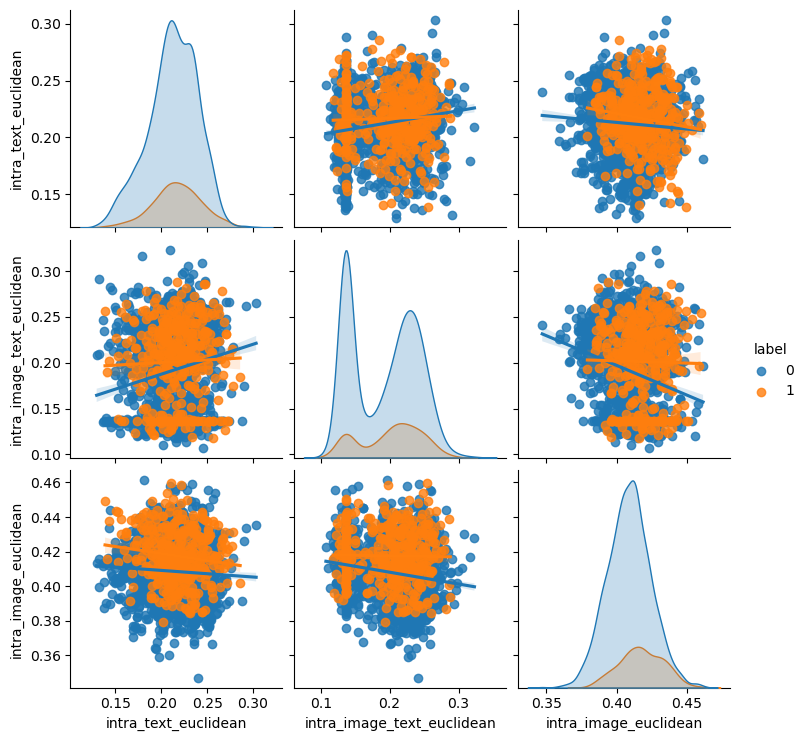

In [201]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(df[["intra_text_euclidean", "intra_image_text_euclidean", "intra_image_euclidean", "label"]], hue="label", kind = "reg")
plt.show()

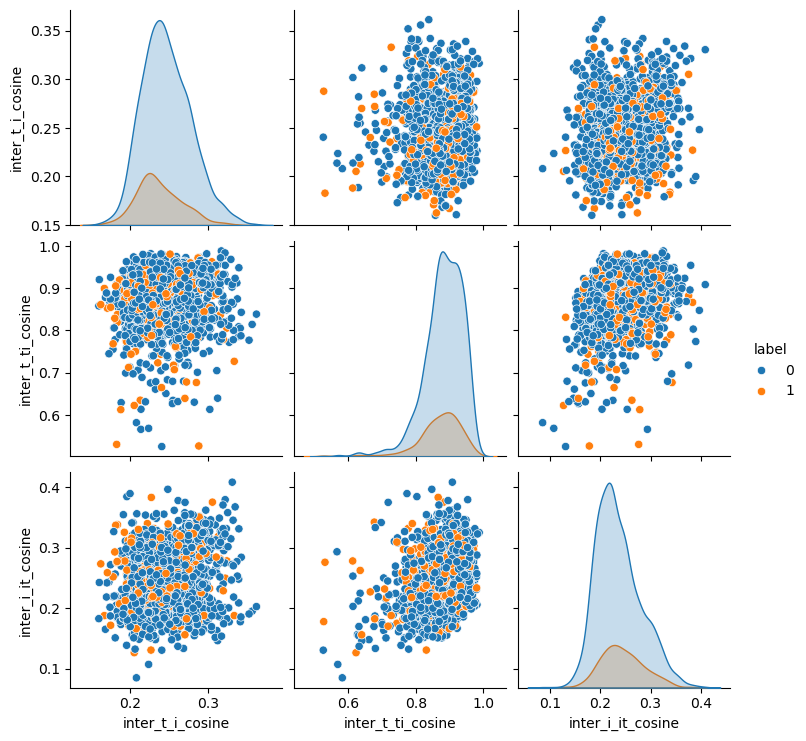

In [200]:
sns.pairplot(df[["inter_t_i_cosine", "inter_t_ti_cosine", "inter_i_it_cosine", "label"]], hue="label")
plt.show()

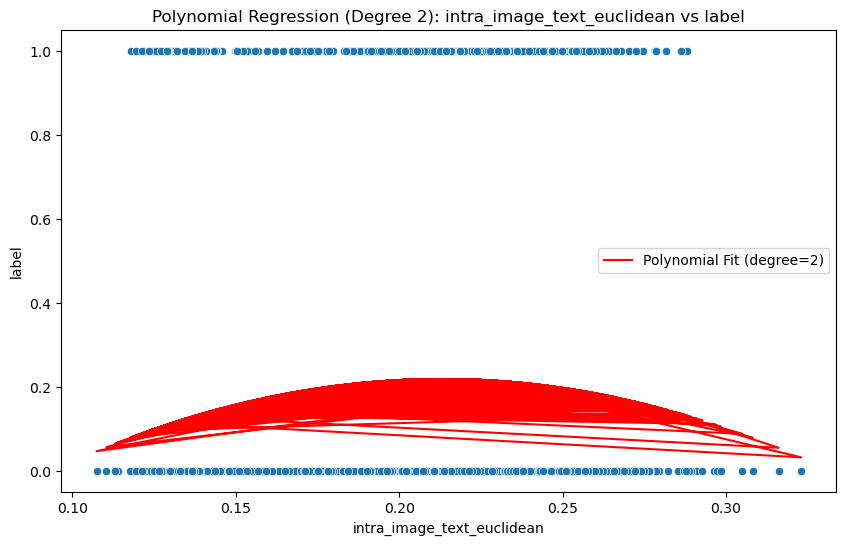

In [204]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
import seaborn as sns
import matplotlib.pyplot as plt

# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df["intra_image_text_euclidean"], y=df["label"])

# Fit polynomial regression (degree 2 for quadratic)
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(df["intra_image_text_euclidean"].values.reshape(-1, 1))
from sklearn.linear_model import LinearRegression
model = LinearRegression().fit(X_poly, df["label"])

# Plot the polynomial regression line
plt.plot(df["intra_image_text_euclidean"], model.predict(X_poly), color="red", label="Polynomial Fit (degree=2)")
plt.title("Polynomial Regression (Degree 2): intra_image_text_euclidean vs label")
plt.legend()
plt.show()


## Nonlinear transformations

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

# Apply Polynomial Transformation (degree 2, quadratic features)
poly = PolynomialFeatures(degree=2)

# Transform the features for intra-modal and inter-modal incongruity
intra_text_poly = poly.fit_transform(df[["intra_text_euclidean"]])
intra_image_poly = poly.fit_transform(df[["intra_image_euclidean"]])
intra_image_text_poly = poly.fit_transform(df[["intra_image_text_euclidean"]])
inter_t_i_poly = poly.fit_transform(df[["inter_t_i_cosine"]])
inter_t_ti_poly = poly.fit_transform(df[["inter_t_ti_cosine"]])
inter_i_it_poly = poly.fit_transform(df[["inter_i_it_cosine"]])

# Add new polynomial features to the DataFrame
df_poly = pd.DataFrame(intra_text_poly[:,1:], columns=["intra_text_sq", "intra_text_euclidean_sq"])
df_poly["intra_image_euclidean_sq"] = intra_image_poly[:, 1] 
df_poly["intra_image_text_euclidean_sq"] = intra_image_text_poly[:, 1]
df_poly["inter_t_i_cosine_sq"] = inter_t_i_poly[:, 1]
df_poly["inter_t_ti_cosine_sq"] = inter_t_ti_poly[:, 1]
df_poly["inter_i_it_cosine_sq"] = inter_i_it_poly[:, 1]

# Add to the original dataframe
df = df.join(df_poly)

In [226]:
print(df[["intra_text_euclidean_sq", "intra_image_euclidean_sq", "intra_image_text_euclidean_sq", "inter_t_i_cosine_sq", "inter_t_ti_cosine_sq", "inter_i_it_cosine_sq"]].isna().sum())

intra_text_euclidean_sq          12
intra_image_euclidean_sq         12
intra_image_text_euclidean_sq    12
inter_t_i_cosine_sq              12
inter_t_ti_cosine_sq             12
inter_i_it_cosine_sq             12
dtype: int64


In [227]:
df = df.dropna(subset=["intra_text_euclidean_sq", "intra_image_euclidean_sq", "intra_image_text_euclidean_sq", "inter_t_i_cosine_sq", "inter_t_ti_cosine_sq", "inter_i_it_cosine_sq"])

In [228]:
# Combine all the features into a single DataFrame
X = df[["intra_text_euclidean_sq", "intra_image_euclidean_sq", "intra_image_text_euclidean_sq", 
        "inter_t_i_cosine_sq", "inter_t_ti_cosine_sq", "inter_i_it_cosine_sq"]]
y = df["label"]

In [229]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [232]:
from sklearn.neural_network import MLPClassifier

# Define a neural network with a few hidden layers
nn_model = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
nn_model.fit(X_train_res, y_train_res)

y_pred_nn = nn_model.predict(X_test)
print(classification_report(y_test, y_pred_nn))

              precision    recall  f1-score   support

           0       0.81      0.77      0.79       354
           1       0.13      0.16      0.14        77

    accuracy                           0.66       431
   macro avg       0.47      0.46      0.47       431
weighted avg       0.69      0.66      0.67       431



yikesies

## Interactions

In [233]:
df["interaction_1"] = df["intra_text_euclidean"] * df["inter_t_i_cosine"]
df["interaction_2"] = df["intra_image_euclidean"] * df["inter_t_ti_cosine"]
df["interaction_3"] = df["intra_image_text_euclidean"] * df["inter_i_it_cosine"]

C:\Users\sirifris\AppData\Local\Temp\ipykernel_92088\316360977.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["interaction_1"] = df["intra_text_euclidean"] * df["inter_t_i_cosine"]
C:\Users\sirifris\AppData\Local\Temp\ipykernel_92088\316360977.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["interaction_2"] = df["intra_image_euclidean"] * df["inter_t_ti_cosine"]
C:\Users\sirifris\AppData\Local\Temp\ipykernel_92088\316360977.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy 

In [235]:
X = df[["intra_text_euclidean", "intra_image_text_euclidean", "intra_image_euclidean",
        "inter_t_i_cosine", "inter_t_ti_cosine", "inter_i_it_cosine",
        "interaction_1", "interaction_2", "interaction_3"]] 
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [236]:
from sklearn.neural_network import MLPClassifier

# Define a neural network with a few hidden layers
nn_model = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
nn_model.fit(X_train_res, y_train_res)

y_pred_nn = nn_model.predict(X_test)
print(classification_report(y_test, y_pred_nn))

              precision    recall  f1-score   support

           0       0.85      0.86      0.86       354
           1       0.32      0.30      0.31        77

    accuracy                           0.76       431
   macro avg       0.59      0.58      0.58       431
weighted avg       0.76      0.76      0.76       431



In [237]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(class_weight="balanced", random_state=42)
rf_model.fit(X_train_res, y_train_res)

y_pred_rf = rf_model.predict(X_test)
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.86      0.85      0.86       354
           1       0.36      0.38      0.37        77

    accuracy                           0.77       431
   macro avg       0.61      0.61      0.61       431
weighted avg       0.77      0.77      0.77       431



## Old testing

In [82]:
def combine_features(text_emb, image_emb):
    """
    Combines text and image embeddings into a single vector.

    Parameters:
        text_emb (np.array): Text embedding vector (512-dim).
        image_emb (np.array): Image embedding vector (512-dim).

    Returns:
        np.array: Concatenated feature vector (1024-dim).
    """
    # Ensure embeddings are numpy arrays
    text_emb = np.array(text_emb).flatten()
    image_emb = np.array(image_emb).flatten()

    # Handle missing image embeddings (use zero vector if missing)
    if np.all(image_emb == 0):  
        print("⚠️ Missing image embedding, using only text features.")

    # Concatenate text and image features
    return np.concatenate([text_emb, image_emb])

# Apply the function to all rows
df["combined_features"] = df.apply(lambda row: combine_features(row["text_features"], row["image_features"]), axis=1)

In [88]:
# Split data before balancing
X_train, X_test, y_train, y_test = train_test_split(df["combined_features"], df["label"], test_size=0.2, random_state=42, stratify=df["label"])

In [89]:
# Convert to NumPy arrays for SMOTE
X_train = np.array(X_train.tolist())  # Convert list of arrays to 2D NumPy array
y_train = np.array(y_train)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Print new class distribution
from collections import Counter
print("Resampled class distribution:", Counter(y_train_resampled))

Resampled class distribution: Counter({0: 1431, 1: 1431})


In [90]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Train Logistic Regression
clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(X_train_resampled, y_train_resampled)

# Predict on the *original, imbalanced* test set
y_pred = clf.predict(np.array(X_test.tolist()))

# Print evaluation metrics
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9134    0.8547    0.8831       358
           1     0.4851    0.6282    0.5475        78

    accuracy                         0.8142       436
   macro avg     0.6993    0.7415    0.7153       436
weighted avg     0.8368    0.8142    0.8231       436



In [91]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Train Logistic Regression
clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(X_train_resampled, y_train_resampled)

# Predict on the *original, imbalanced* test set
y_pred = clf.predict(np.array(X_test.tolist()))

# Print evaluation metrics
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9134    0.8547    0.8831       358
           1     0.4851    0.6282    0.5475        78

    accuracy                         0.8142       436
   macro avg     0.6993    0.7415    0.7153       436
weighted avg     0.8368    0.8142    0.8231       436



In [92]:
# Looking at the false predictions
df_test = pd.DataFrame({ "tweet": df.loc[X_test.index, "combined_text"], 
                        "image_path": df.loc[X_test.index, "image_path_image_filename_image_1"],
                        "true_label": y_test,
                        "pred_label": y_pred})

# Extract misclassified samples
false_positives = df_test[(df_test["true_label"] == 0) & (df_test["pred_label"] == 1)]
false_negatives = df_test[(df_test["true_label"] == 1) & (df_test["pred_label"] == 0)]

# Display a few misclassified examples
print("\n🔹 False Positives (Non-humor misclassified as humor):")
print(false_positives.head(5))  # Show 5 examples

print("\n🔹 False Negatives (Humor misclassified as non-humor):")
print(false_negatives.head(5))  # Show 5 examples


🔹 False Positives (Non-humor misclassified as humor):
                                                  tweet  \
1999  Kjekt å ta koronatest når alle mine blir rare ...   
985   Altså, jeg skal delta i dette som i så godt so...   
1908  Etter to års pandemi skal USERNAME teste noe i...   
1853  – Hvis pressen la ned i morgen – ville vi da m...   
493   USERNAME USERNAME USERNAME USERNAME Hvis du pr...   

                                        image_path  true_label  pred_label  
1999  E:/Images/Covid/images_1/FM__t2TWQAUJVC6.jpg           0           1  
985   E:/Images/Covid/images_2/EmdQHXyXYAUn3Vu.png           0           1  
1908  E:/Images/Covid/images_1/FIcOgrMXoAYFFnU.png           0           1  
1853  E:/Images/Covid/images_1/FH8ZknGWYAgcZKx.jpg           0           1  
493   E:/Images/Covid/images_2/EWsyLoBU0AI2XYc.png           0           1  

🔹 False Negatives (Humor misclassified as non-humor):
                                                  tweet  \
2147  Hahaha….

C:\Users\sirifris\AppData\Local\Temp\ipykernel_693504\3379348830.py:22: UserWarning: Glyph 128580 (\N{FACE WITH ROLLING EYES}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\sirifris\.conda\envs\poli_reco\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128580 (\N{FACE WITH ROLLING EYES}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


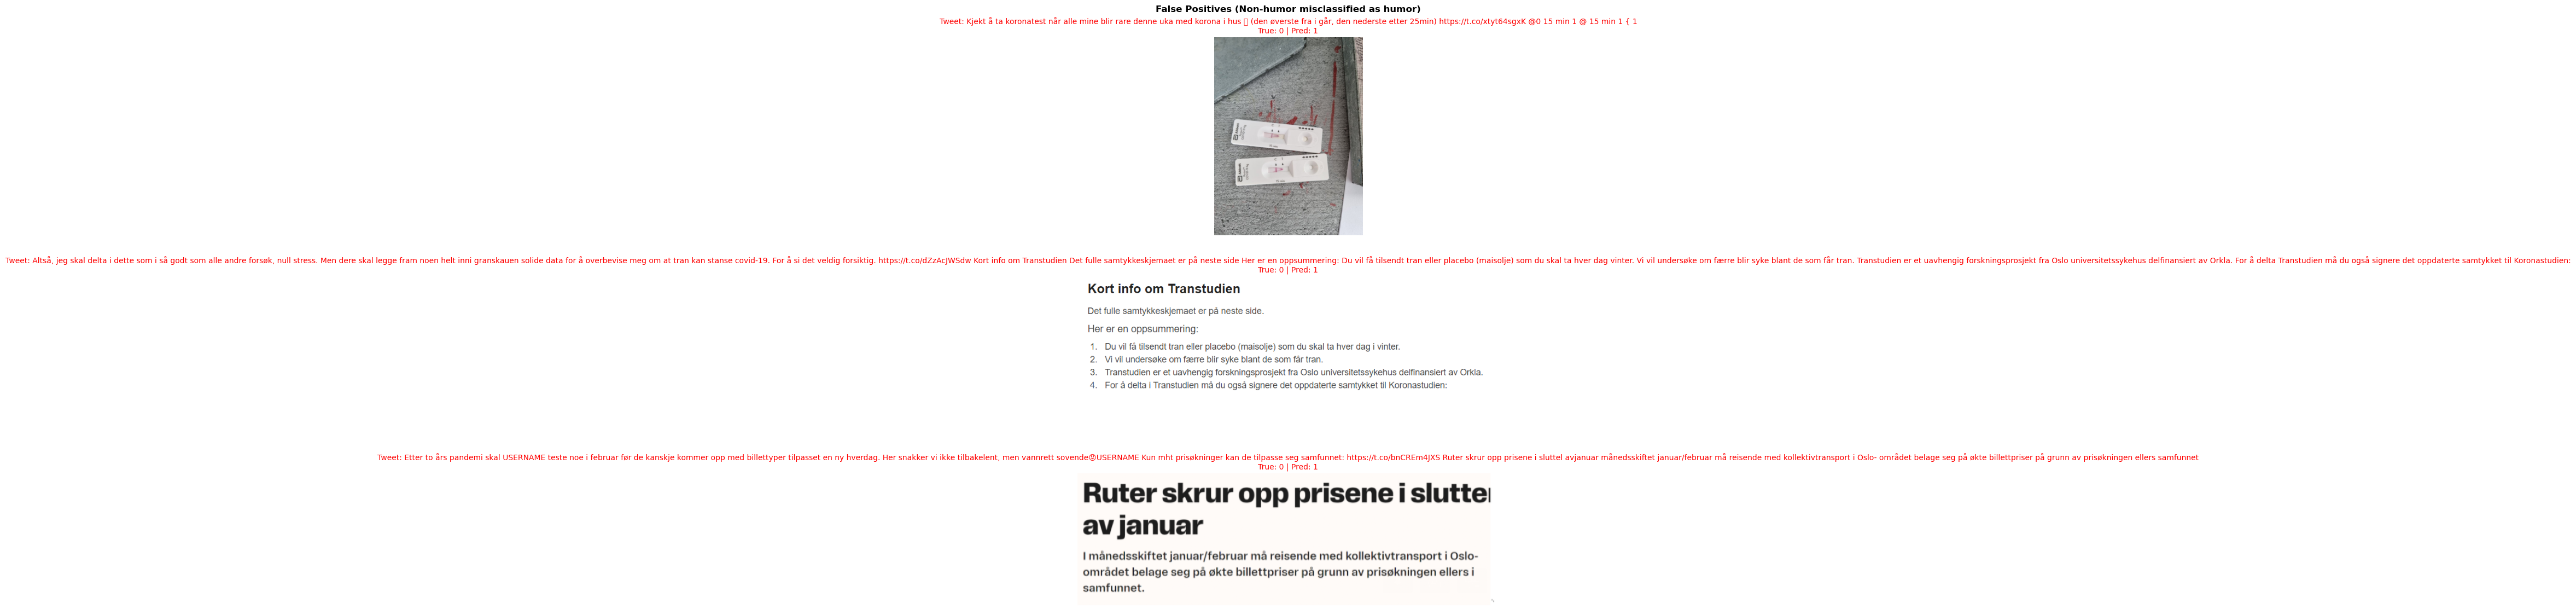

C:\Users\sirifris\AppData\Local\Temp\ipykernel_693504\3379348830.py:22: UserWarning: Glyph 129313 (\N{CLOWN FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\sirifris\.conda\envs\poli_reco\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129313 (\N{CLOWN FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


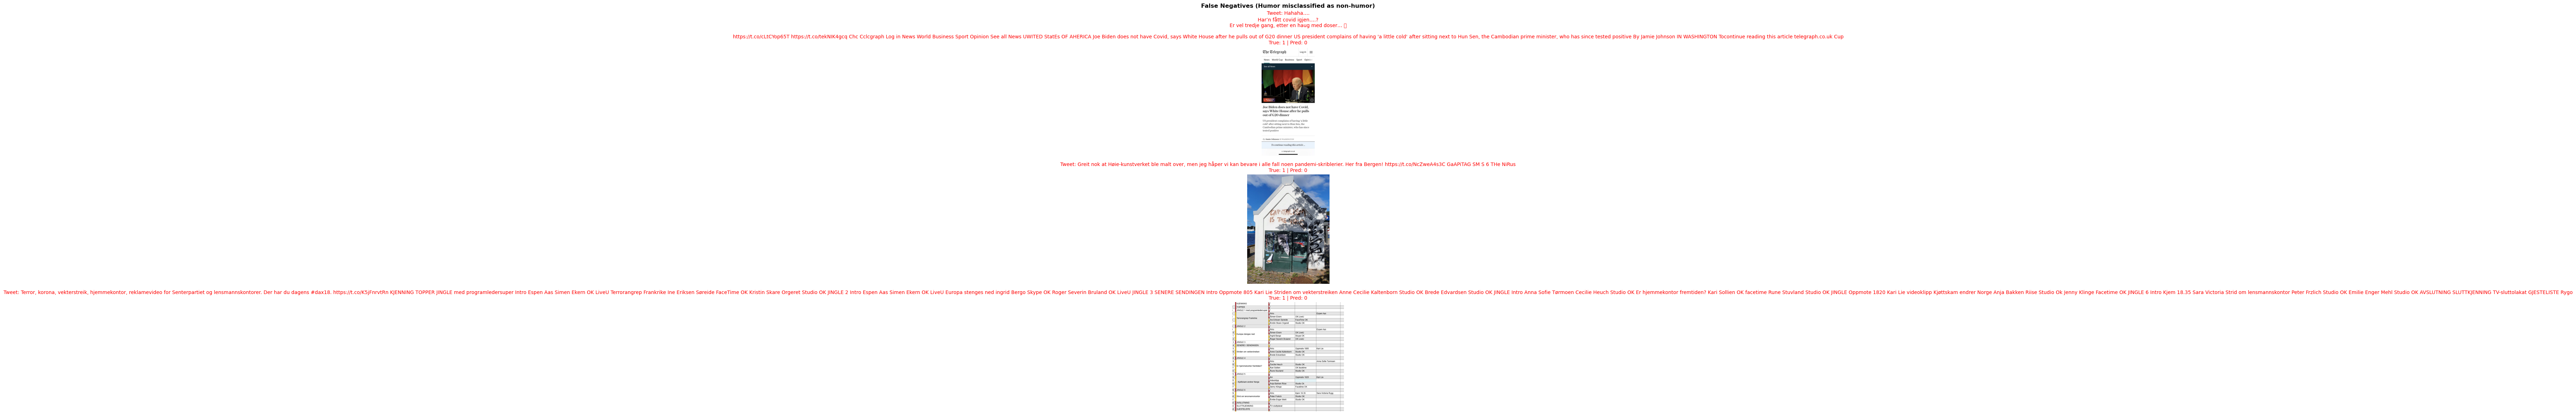

In [93]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_misclassified_samples(df_subset, title):
    """Displays misclassified examples with text and images."""
    fig, axes = plt.subplots(len(df_subset), 1, figsize=(8, len(df_subset) * 4))

    for i, (_, row) in enumerate(df_subset.iterrows()):
        # Load image if available
        img = mpimg.imread(row["image_path"]) if pd.notna(row["image_path"]) else None
        
        # Display image if present
        if img is not None:
            axes[i].imshow(img)
            axes[i].axis("off")

        # Display tweet text and labels
        text_info = f"Tweet: {row['tweet']}\nTrue: {row['true_label']} | Pred: {row['pred_label']}"
        axes[i].set_title(text_info, fontsize=10, color="red" if row['true_label'] != row['pred_label'] else "black")

    plt.suptitle(title, fontsize=12, fontweight="bold")
    plt.tight_layout()
    plt.show()

# Show misclassified examples
show_misclassified_samples(false_positives.head(3), "False Positives (Non-humor misclassified as humor)")
show_misclassified_samples(false_negatives.head(3), "False Negatives (Humor misclassified as non-humor)")